In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import numpy as np
import tensorflow as tf

from gantools import data
from gantools import utils
from gantools import plot
from gantools.model import WGAN
from gantools.gansystem import GANsystem
from gantools.data import fmap
from gantools import evaluation
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

# Parameters

In [3]:
ns = 32 # Resolution of the image
scaling = 64
try_resume = True

# Data handling

Load the data

In [4]:
dataset = data.load.load_maps_dataset(spix=ns, scaling=scaling, augmentation=True, patch=False)

images shape =  (200, 2304, 2560, 3)


In [5]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 32, 32, 3)


In [6]:
# Get all the data
X = dataset.get_all_data().flatten()

Display the histogram of the pixel densities after the forward map

min: 0.03764135390520096
max: 0.9922178983688354


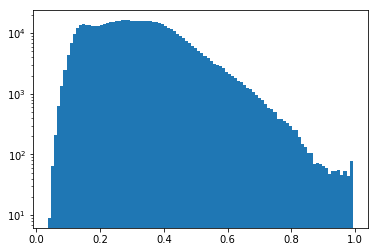

In [7]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [8]:
# to free some memory
del X

Let us plot 16 images

Text(0.5,1,'Real samples')

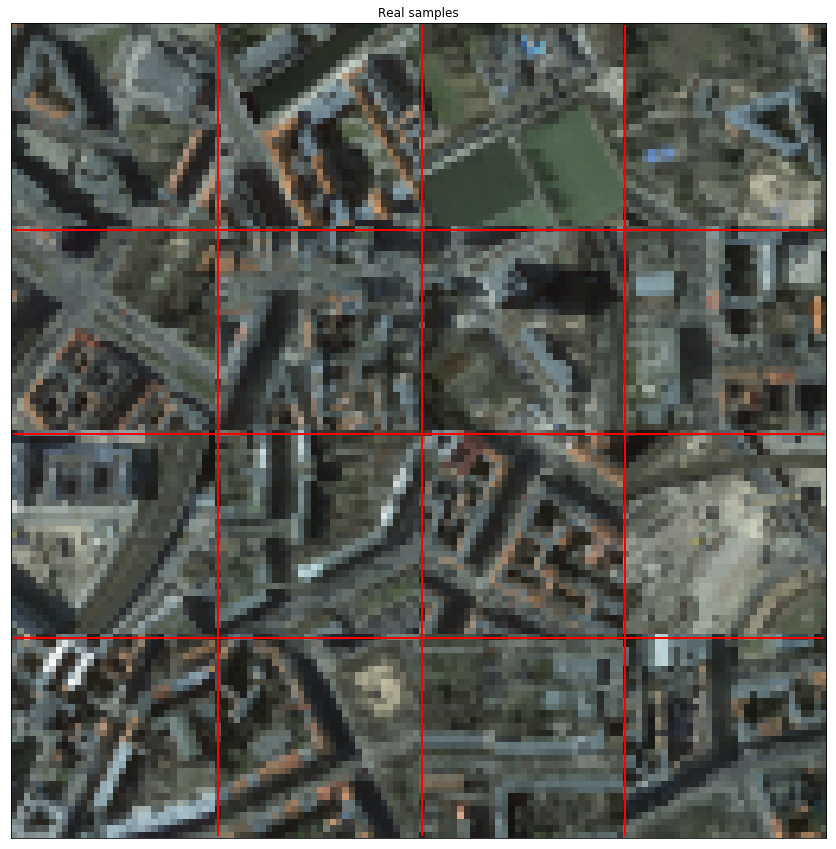

In [9]:
plt.figure(figsize=(15,15))
plot.draw_images(dataset.get_samples(N=16),nx=4,ny=4);
plt.title("Real samples")

# Define parameters for the WGAN

In [10]:
time_str = 'maps_scaling{}_big'.format(scaling)
global_path = '../saved_results'

name = 'WGAN{}'.format(ns) + '_' + time_str

## Parameters

In [11]:
bn = False

def non_lin(x):
    return (tf.nn.tanh(x) + 1.0)/2.0

md=32

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 1, 1, 1, 1]
params_discriminator['nfilter'] = [md, 4*md, 16*md, 16*md, 16*md, 8]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [5, 5], [5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn, bn]
params_discriminator['full'] = [512, 256]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2
params_discriminator['inception'] = True
params_discriminator['spectral_norm'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 1, 1, 1, 1]
params_generator['latent_dim'] = 256
params_generator['nfilter'] = [64*md, 16*md, 4*md, md, md, md, 3]
params_generator['shape'] = [[3, 3], [5, 5],[5, 5], [5, 5],[5, 5],[5, 5],[5, 5]]
params_generator['batch_norm'] = [False, False, False, False, False, False]
params_generator['full'] = [4*4*16]
params_generator['summary'] = True
params_generator['non_lin'] = non_lin
params_generator['data_size'] = 2
params_generator['inception'] = True
params_generator['spectral_norm'] = True

params_optimization = dict()
params_optimization['batch_size'] = 16
params_optimization['epoch'] = 10000
params_optimization['n_critic'] = 2
params_optimization['generator'] = dict()
params_optimization['generator']['optimizer'] = 'adam'
params_optimization['generator']['kwargs'] = {'beta1':0, 'beta2':0.9}
params_optimization['generator']['learning_rate'] = 0.0004
params_optimization['discriminator'] = dict()
params_optimization['discriminator']['optimizer'] = 'adam'
params_optimization['discriminator']['kwargs'] = {'beta1':0, 'beta2':0.9}
params_optimization['discriminator']['learning_rate'] = 0.0001


# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 3] # Shape of the image
# params['net']['gamma_gp'] = 10 # Gradient penalty
params['net']['upsampling'] = None 

params['optimization'] = params_optimization
params['summary_every'] = 100 # Tensorboard summaries every ** iterations
params['print_every'] = 50 # Console summaries every ** iterations
params['save_every'] = 1000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 100

resume, params = utils.test_resume(try_resume, params)


No resume, the training will start from the beginning!


# Build the model

In [12]:
wgan = GANsystem(WGAN, params)

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     0 Full layer with 256 outputs
         Size of the variables: (?, 256)
     Reshape to (?, 4, 4, 16)
     0 Inception deconv(1x1,3x3,5x5) layer with 2048 channels
         Non linearity applied
         Size of the variables: (?, 8, 8, 6144)
     1 Inception deconv(1x1,3x3,5x5) layer with 512 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 1536)
     2 Inception deconv(1x1,3x3,5x5) layer with 128 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 384)
     3 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 96)
     4 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 96)
     5 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
    

# Train the model

In [13]:
wgan.train(dataset, resume=resume)

Compute real statistics: descriptives/mean_l2
Compute real statistics: descriptives/var_l2
Compute real statistics: descriptives/min_l2
Compute real statistics: descriptives/max_l2
Compute real statistics: descriptives/kurtosis_l2
Compute real statistics: descriptives/skewness_l2
Compute real statistics: descriptives/median_l2
Erase recursively directory: ../saved_results/WGAN32_maps_scaling64_big_summary/
Erase recursively directory: ../saved_results/WGAN32_maps_scaling64_big_checkpoints/
Start training
 * Epoch: [ 4] [   2/  12] Counter:50	( 1.1 min	12.282 examples/sec	1.30 sec/batch)
   Disc batch loss:1.96390700	Disc epoch loss:1.86593610
   Gen batch loss:-0.38481671	Gen epoch loss:-0.47826505
 * Epoch: [ 8] [   4/  12] Counter:100	( 2.0 min	14.233 examples/sec	1.12 sec/batch)
   Disc batch loss:1.74854422	Disc epoch loss:1.63658747
   Gen batch loss:0.08194620	Gen epoch loss:-0.06234575
 * Epoch: [12] [   6/  12] Counter:150	( 3.1 min	12.253 examples/sec	1.31 sec/batch)
   Disc b

 * Epoch: [166] [   8/  12] Counter:2000	(38.5 min	14.125 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.63858169
   Gen batch loss:1.92854881	Gen epoch loss:0.71351649
Model saved!
 * Epoch: [170] [  10/  12] Counter:2050	(39.6 min	12.640 examples/sec	1.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.53751003
   Gen batch loss:3.25763249	Gen epoch loss:1.89704174
 * Epoch: [174] [  12/  12] Counter:2100	(40.5 min	14.164 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.42323034
   Gen batch loss:1.74324882	Gen epoch loss:0.84069785
 * Epoch: [179] [   2/  12] Counter:2150	(41.5 min	13.786 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23783448
   Gen batch loss:1.39264512	Gen epoch loss:0.95848808
 * Epoch: [183] [   4/  12] Counter:2200	(42.4 min	14.112 examples/sec	1.13 sec/batch)
   Disc batch loss:0.55063719	Disc epoch loss:0.24849497
   Gen batch loss:0.44936281	Gen epoch loss:1.3

 * Epoch: [337] [   6/  12] Counter:4050	(78.0 min	12.634 examples/sec	1.27 sec/batch)
   Disc batch loss:0.14439070	Disc epoch loss:0.44927333
   Gen batch loss:3.52326441	Gen epoch loss:2.56681178
 * Epoch: [341] [   8/  12] Counter:4100	(78.9 min	14.126 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.48831224
   Gen batch loss:1.82567060	Gen epoch loss:2.36240952
 * Epoch: [345] [  10/  12] Counter:4150	(79.9 min	13.750 examples/sec	1.16 sec/batch)
   Disc batch loss:0.76475132	Disc epoch loss:0.22662317
   Gen batch loss:0.57369214	Gen epoch loss:2.20491428
 * Epoch: [349] [  12/  12] Counter:4200	(80.8 min	14.145 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.23356801
   Gen batch loss:1.84786296	Gen epoch loss:1.50428947
 * Epoch: [354] [   2/  12] Counter:4250	(81.8 min	13.774 examples/sec	1.16 sec/batch)
   Disc batch loss:0.54482359	Disc epoch loss:0.69433844
   Gen batch loss:0.45517641	Gen epoch loss:0.30566156
 * Ep

 * Epoch: [508] [   4/  12] Counter:6100	(117.4 min	14.113 examples/sec	1.13 sec/batch)
   Disc batch loss:0.18190432	Disc epoch loss:0.39925864
   Gen batch loss:0.81809568	Gen epoch loss:0.79409479
 * Epoch: [512] [   6/  12] Counter:6150	(118.3 min	13.771 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04688268
   Gen batch loss:1.08117342	Gen epoch loss:1.32356750
 * Epoch: [516] [   8/  12] Counter:6200	(119.3 min	14.130 examples/sec	1.13 sec/batch)
   Disc batch loss:0.01589954	Disc epoch loss:0.10601620
   Gen batch loss:0.98410046	Gen epoch loss:2.09411909
 * Epoch: [520] [  10/  12] Counter:6250	(120.2 min	13.749 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.46319578
   Gen batch loss:2.05849242	Gen epoch loss:1.90916137
 * Epoch: [524] [  12/  12] Counter:6300	(121.2 min	14.114 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.38666866
   Gen batch loss:2.37786937	Gen epoch loss:2.13910527


 * Epoch: [679] [   2/  12] Counter:8150	(156.7 min	13.780 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.96185303	Gen epoch loss:2.89260614
 * Epoch: [683] [   4/  12] Counter:8200	(157.7 min	14.062 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.73443675	Gen epoch loss:1.78735459
 * Epoch: [687] [   6/  12] Counter:8250	(158.7 min	13.766 examples/sec	1.16 sec/batch)
   Disc batch loss:0.22155702	Disc epoch loss:0.13265805
   Gen batch loss:0.77844298	Gen epoch loss:1.46257817
 * Epoch: [691] [   8/  12] Counter:8300	(159.6 min	14.106 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.11823368	Gen epoch loss:2.24018580
 * Epoch: [695] [  10/  12] Counter:8350	(160.6 min	13.775 examples/sec	1.16 sec/batch)
   Disc batch loss:0.47917861	Disc epoch loss:0.29739003
   Gen batch loss:0.52082139	Gen epoch loss:1.61301653


 * Epoch: [849] [  12/  12] Counter:10200	(196.1 min	14.111 examples/sec	1.13 sec/batch)
   Disc batch loss:0.14063227	Disc epoch loss:0.21561390
   Gen batch loss:0.85936773	Gen epoch loss:1.36264807
 * Epoch: [854] [   2/  12] Counter:10250	(197.1 min	13.749 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.67538595	Gen epoch loss:2.82059073
 * Epoch: [858] [   4/  12] Counter:10300	(198.0 min	14.154 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.19736661
   Gen batch loss:2.18717766	Gen epoch loss:1.19541894
 * Epoch: [862] [   6/  12] Counter:10350	(199.0 min	13.793 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.10815441
   Gen batch loss:3.97491217	Gen epoch loss:1.99020073
 * Epoch: [866] [   8/  12] Counter:10400	(199.9 min	14.108 examples/sec	1.13 sec/batch)
   Disc batch loss:0.44515848	Disc epoch loss:0.63051303
   Gen batch loss:0.55484152	Gen epoch loss:1.1481

 * Epoch: [1020] [  10/  12] Counter:12250	(235.5 min	13.778 examples/sec	1.16 sec/batch)
   Disc batch loss:0.75305521	Disc epoch loss:0.20475982
   Gen batch loss:4.63315201	Gen epoch loss:2.68544989
 * Epoch: [1024] [  12/  12] Counter:12300	(236.4 min	14.131 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.31598596
   Gen batch loss:1.07580960	Gen epoch loss:1.41126849
 * Epoch: [1029] [   2/  12] Counter:12350	(237.4 min	13.775 examples/sec	1.16 sec/batch)
   Disc batch loss:0.60776854	Disc epoch loss:0.40901053
   Gen batch loss:2.67402768	Gen epoch loss:1.73188758
 * Epoch: [1033] [   4/  12] Counter:12400	(238.3 min	14.127 examples/sec	1.13 sec/batch)
   Disc batch loss:1.23845243	Disc epoch loss:0.74252349
   Gen batch loss:-0.23845237	Gen epoch loss:0.54563583
 * Epoch: [1037] [   6/  12] Counter:12450	(239.3 min	13.780 examples/sec	1.16 sec/batch)
   Disc batch loss:0.88130689	Disc epoch loss:0.21881696
   Gen batch loss:5.36220074	Gen epoch loss:

 * Epoch: [1199] [  12/  12] Counter:14400	(276.8 min	14.121 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.07458162	Gen epoch loss:2.21973350
 * Epoch: [1204] [   2/  12] Counter:14450	(277.7 min	13.761 examples/sec	1.16 sec/batch)
   Disc batch loss:1.24197984	Disc epoch loss:0.62098992
   Gen batch loss:2.90590405	Gen epoch loss:2.72046220
 * Epoch: [1208] [   4/  12] Counter:14500	(278.7 min	14.113 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07661837
   Gen batch loss:2.93301606	Gen epoch loss:2.76254457
 * Epoch: [1212] [   6/  12] Counter:14550	(279.7 min	13.784 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25564439
   Gen batch loss:2.61450624	Gen epoch loss:2.57893695
 * Epoch: [1216] [   8/  12] Counter:14600	(280.6 min	14.112 examples/sec	1.13 sec/batch)
   Disc batch loss:1.11431837	Disc epoch loss:0.27903745
   Gen batch loss:-0.11431833	Gen epoch loss:

 * Epoch: [1370] [  10/  12] Counter:16450	(316.2 min	13.759 examples/sec	1.16 sec/batch)
   Disc batch loss:0.01076907	Disc epoch loss:0.07661555
   Gen batch loss:0.98923093	Gen epoch loss:2.28915542
 * Epoch: [1374] [  12/  12] Counter:16500	(317.1 min	14.144 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.12710665
   Gen batch loss:2.39319897	Gen epoch loss:2.45444149
 * Epoch: [1379] [   2/  12] Counter:16550	(318.1 min	13.766 examples/sec	1.16 sec/batch)
   Disc batch loss:0.44250506	Disc epoch loss:0.56705830
   Gen batch loss:0.55749494	Gen epoch loss:0.43294169
 * Epoch: [1383] [   4/  12] Counter:16600	(319.0 min	14.122 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13710023
   Gen batch loss:2.67101073	Gen epoch loss:2.33837044
 * Epoch: [1387] [   6/  12] Counter:16650	(320.0 min	13.744 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13850733
   Gen batch loss:2.82629371	Gen epoch loss:1

 * Epoch: [1541] [   8/  12] Counter:18500	(355.5 min	14.096 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00234018
   Gen batch loss:4.97544384	Gen epoch loss:2.78080185
 * Epoch: [1545] [  10/  12] Counter:18550	(356.5 min	13.745 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03441449
   Gen batch loss:1.34226227	Gen epoch loss:3.11028719
 * Epoch: [1549] [  12/  12] Counter:18600	(357.4 min	14.134 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13233118
   Gen batch loss:1.83935964	Gen epoch loss:2.84976150
 * Epoch: [1554] [   2/  12] Counter:18650	(358.4 min	13.770 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.78371334	Gen epoch loss:2.68991333
 * Epoch: [1558] [   4/  12] Counter:18700	(359.4 min	14.094 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13484961
   Gen batch loss:4.66222429	Gen epoch loss:3

 * Epoch: [1712] [   6/  12] Counter:20550	(394.9 min	13.763 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.16397882	Gen epoch loss:2.51309341
 * Epoch: [1716] [   8/  12] Counter:20600	(395.9 min	14.137 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.11290966
   Gen batch loss:2.37422562	Gen epoch loss:2.25363074
 * Epoch: [1720] [  10/  12] Counter:20650	(396.8 min	13.773 examples/sec	1.16 sec/batch)
   Disc batch loss:0.23439384	Disc epoch loss:0.02343938
   Gen batch loss:0.76560616	Gen epoch loss:2.45209283
 * Epoch: [1724] [  12/  12] Counter:20700	(397.8 min	14.107 examples/sec	1.13 sec/batch)
   Disc batch loss:0.07928699	Disc epoch loss:0.32738929
   Gen batch loss:0.92071301	Gen epoch loss:2.43076098
 * Epoch: [1729] [   2/  12] Counter:20750	(398.8 min	13.760 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.50220084	Gen epoch loss:3

 * Epoch: [1883] [   4/  12] Counter:22600	(434.3 min	14.137 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.57322380
   Gen batch loss:1.67396307	Gen epoch loss:1.34130557
 * Epoch: [1887] [   6/  12] Counter:22650	(435.3 min	13.782 examples/sec	1.16 sec/batch)
   Disc batch loss:1.00661504	Disc epoch loss:0.16776917
   Gen batch loss:-0.00661504	Gen epoch loss:1.66509501
 * Epoch: [1891] [   8/  12] Counter:22700	(436.2 min	14.121 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.52432156	Gen epoch loss:3.11287440
 * Epoch: [1895] [  10/  12] Counter:22750	(437.2 min	13.771 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.28413023
   Gen batch loss:1.54724562	Gen epoch loss:2.01309424
 * Epoch: [1899] [  12/  12] Counter:22800	(438.1 min	14.117 examples/sec	1.13 sec/batch)
   Disc batch loss:0.18509817	Disc epoch loss:0.14827388
   Gen batch loss:0.81490183	Gen epoch loss:

 * Epoch: [2054] [   2/  12] Counter:24650	(473.7 min	13.750 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.75543404	Gen epoch loss:3.03292799
 * Epoch: [2058] [   4/  12] Counter:24700	(474.6 min	14.148 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.08866072	Gen epoch loss:2.22869217
 * Epoch: [2062] [   6/  12] Counter:24750	(475.6 min	13.743 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.49089026	Gen epoch loss:2.33267665
 * Epoch: [2066] [   8/  12] Counter:24800	(476.6 min	14.123 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03534172
   Gen batch loss:1.73770297	Gen epoch loss:2.05843359
 * Epoch: [2070] [  10/  12] Counter:24850	(477.5 min	13.789 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.39818285
   Gen batch loss:4.02798510	Gen epoch loss:2

 * Epoch: [2224] [  12/  12] Counter:26700	(513.1 min	14.131 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06170764
   Gen batch loss:1.41865778	Gen epoch loss:2.18696744
 * Epoch: [2229] [   2/  12] Counter:26750	(514.0 min	13.772 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.45133209	Gen epoch loss:3.52011800
 * Epoch: [2233] [   4/  12] Counter:26800	(515.0 min	14.127 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.64141798	Gen epoch loss:3.89391214
 * Epoch: [2237] [   6/  12] Counter:26850	(515.9 min	13.787 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.52533436	Gen epoch loss:3.42183773
 * Epoch: [2241] [   8/  12] Counter:26900	(516.9 min	14.114 examples/sec	1.13 sec/batch)
   Disc batch loss:0.86357915	Disc epoch loss:0.16550873
   Gen batch loss:0.13642088	Gen epoch loss:2

 * Epoch: [2395] [  10/  12] Counter:28750	(552.5 min	13.779 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17682732
   Gen batch loss:2.34329104	Gen epoch loss:1.76111639
 * Epoch: [2399] [  12/  12] Counter:28800	(553.4 min	14.107 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.10845367
   Gen batch loss:3.54203510	Gen epoch loss:2.01461821
 * Epoch: [2404] [   2/  12] Counter:28850	(554.4 min	13.770 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.74157143	Gen epoch loss:2.42325771
 * Epoch: [2408] [   4/  12] Counter:28900	(555.3 min	14.084 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.11326027	Gen epoch loss:3.87536776
 * Epoch: [2412] [   6/  12] Counter:28950	(556.3 min	13.762 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.93267894	Gen epoch loss:2

 * Epoch: [2566] [   8/  12] Counter:30800	(591.8 min	14.118 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13683137
   Gen batch loss:3.51065350	Gen epoch loss:2.44653231
 * Epoch: [2570] [  10/  12] Counter:30850	(592.8 min	13.777 examples/sec	1.16 sec/batch)
   Disc batch loss:0.09429622	Disc epoch loss:0.10519484
   Gen batch loss:0.90570378	Gen epoch loss:1.83352708
 * Epoch: [2574] [  12/  12] Counter:30900	(593.7 min	14.121 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06188267
   Gen batch loss:4.45293570	Gen epoch loss:3.15438887
 * Epoch: [2579] [   2/  12] Counter:30950	(594.7 min	13.758 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.63249373	Gen epoch loss:3.57301402
 * Epoch: [2583] [   4/  12] Counter:31000	(595.7 min	14.127 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.73344946	Gen epoch loss:2

 * Epoch: [2737] [   6/  12] Counter:32850	(631.2 min	13.787 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.09634876	Gen epoch loss:2.94259051
 * Epoch: [2741] [   8/  12] Counter:32900	(632.2 min	14.136 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25798051
   Gen batch loss:3.74906492	Gen epoch loss:1.62812142
 * Epoch: [2745] [  10/  12] Counter:32950	(633.1 min	13.756 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.25922037
   Gen batch loss:4.23506784	Gen epoch loss:2.33679343
 * Epoch: [2749] [  12/  12] Counter:33000	(634.1 min	14.124 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09085295
   Gen batch loss:2.33743167	Gen epoch loss:2.64202648
Model saved!
 * Epoch: [2754] [   2/  12] Counter:33050	(635.1 min	12.643 examples/sec	1.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.45626855	Gen

 * Epoch: [2908] [   4/  12] Counter:34900	(670.6 min	14.143 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.56335688
   Gen batch loss:4.08675003	Gen epoch loss:2.92336094
 * Epoch: [2912] [   6/  12] Counter:34950	(671.6 min	13.770 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.82828474	Gen epoch loss:3.79688342
 * Epoch: [2916] [   8/  12] Counter:35000	(672.5 min	14.112 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.12908211
   Gen batch loss:2.77938151	Gen epoch loss:4.16847765
Model saved!
 * Epoch: [2920] [  10/  12] Counter:35050	(673.6 min	12.651 examples/sec	1.26 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.42972381
   Gen batch loss:1.60269761	Gen epoch loss:2.38333516
 * Epoch: [2924] [  12/  12] Counter:35100	(674.5 min	14.096 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16503902
   Gen batch loss:8.98500824	Gen

 * Epoch: [3079] [   2/  12] Counter:36950	(710.0 min	13.764 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.95976222	Gen epoch loss:2.98826247
 * Epoch: [3083] [   4/  12] Counter:37000	(711.0 min	14.113 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.27527618	Gen epoch loss:4.26553470
Model saved!
 * Epoch: [3087] [   6/  12] Counter:37050	(712.0 min	12.650 examples/sec	1.26 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06174365
   Gen batch loss:5.07721233	Gen epoch loss:3.04334085
 * Epoch: [3091] [   8/  12] Counter:37100	(712.9 min	14.133 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08975534
   Gen batch loss:3.66051078	Gen epoch loss:2.56008784
 * Epoch: [3095] [  10/  12] Counter:37150	(713.9 min	13.780 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13167586
   Gen batch loss:2.47676563	Gen

 * Epoch: [3249] [  12/  12] Counter:39000	(749.4 min	14.129 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.74647105	Gen epoch loss:2.43567692
Model saved!
 * Epoch: [3254] [   2/  12] Counter:39050	(750.4 min	12.628 examples/sec	1.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:1.13907099
   Gen batch loss:4.39382792	Gen epoch loss:4.51488686
 * Epoch: [3258] [   4/  12] Counter:39100	(751.4 min	14.121 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06214325
   Gen batch loss:2.72080207	Gen epoch loss:2.34419598
 * Epoch: [3262] [   6/  12] Counter:39150	(752.3 min	13.786 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.05005169	Gen epoch loss:2.53518287
 * Epoch: [3266] [   8/  12] Counter:39200	(753.3 min	14.105 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.26372337	Gen

Model saved!
 * Epoch: [3420] [  10/  12] Counter:41050	(788.9 min	12.653 examples/sec	1.26 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.10854169
   Gen batch loss:3.10925627	Gen epoch loss:2.60363289
 * Epoch: [3424] [  12/  12] Counter:41100	(789.8 min	14.145 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.01253319	Gen epoch loss:3.02999582
 * Epoch: [3429] [   2/  12] Counter:41150	(790.8 min	13.746 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.38431597	Gen epoch loss:3.90544128
 * Epoch: [3433] [   4/  12] Counter:41200	(791.7 min	14.112 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.15503263	Gen epoch loss:2.49690211
 * Epoch: [3437] [   6/  12] Counter:41250	(792.7 min	13.772 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.18907660
   Gen batch loss:1.22095037	Gen

 * Epoch: [3591] [   8/  12] Counter:43100	(828.2 min	14.145 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.11257792	Gen epoch loss:3.46887973
 * Epoch: [3595] [  10/  12] Counter:43150	(829.2 min	13.765 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09332005
   Gen batch loss:3.83617544	Gen epoch loss:2.65611119
 * Epoch: [3599] [  12/  12] Counter:43200	(830.1 min	14.109 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.39108877
   Gen batch loss:2.23819113	Gen epoch loss:3.31378922
 * Epoch: [3604] [   2/  12] Counter:43250	(831.1 min	13.744 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.64722157	Gen epoch loss:2.81394660
 * Epoch: [3608] [   4/  12] Counter:43300	(832.1 min	14.117 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:7.56719303	Gen epoch loss:4

 * Epoch: [3762] [   6/  12] Counter:45150	(867.6 min	13.777 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.76842546	Gen epoch loss:2.33398702
 * Epoch: [3766] [   8/  12] Counter:45200	(868.6 min	14.126 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04010957
   Gen batch loss:2.33323407	Gen epoch loss:2.23213045
 * Epoch: [3770] [  10/  12] Counter:45250	(869.5 min	13.751 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00231043
   Gen batch loss:3.87733865	Gen epoch loss:2.56748948
 * Epoch: [3774] [  12/  12] Counter:45300	(870.5 min	14.121 examples/sec	1.13 sec/batch)
   Disc batch loss:0.01352686	Disc epoch loss:0.01856537
   Gen batch loss:0.98647314	Gen epoch loss:2.52103201
 * Epoch: [3779] [   2/  12] Counter:45350	(871.5 min	13.766 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.07402420	Gen epoch loss:4

 * Epoch: [3933] [   4/  12] Counter:47200	(907.0 min	14.120 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.61157942	Gen epoch loss:2.98168018
 * Epoch: [3937] [   6/  12] Counter:47250	(908.0 min	13.744 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15421073
   Gen batch loss:1.99462700	Gen epoch loss:2.64564788
 * Epoch: [3941] [   8/  12] Counter:47300	(908.9 min	14.128 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00183967
   Gen batch loss:4.04131556	Gen epoch loss:3.76539227
 * Epoch: [3945] [  10/  12] Counter:47350	(909.9 min	13.763 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05803549
   Gen batch loss:4.57492971	Gen epoch loss:3.77277482
 * Epoch: [3949] [  12/  12] Counter:47400	(910.8 min	14.120 examples/sec	1.13 sec/batch)
   Disc batch loss:1.61501861	Disc epoch loss:0.13458488
   Gen batch loss:-0.61501867	Gen epoch loss:

 * Epoch: [4104] [   2/  12] Counter:49250	(946.4 min	13.776 examples/sec	1.16 sec/batch)
   Disc batch loss:0.11436188	Disc epoch loss:0.05718094
   Gen batch loss:0.88563812	Gen epoch loss:1.35118133
 * Epoch: [4108] [   4/  12] Counter:49300	(947.4 min	14.117 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.48648822	Gen epoch loss:2.96269140
 * Epoch: [4112] [   6/  12] Counter:49350	(948.3 min	13.758 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.34013204
   Gen batch loss:5.03201294	Gen epoch loss:4.90913796
 * Epoch: [4116] [   8/  12] Counter:49400	(949.3 min	14.117 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.59308672	Gen epoch loss:3.23948406
 * Epoch: [4120] [  10/  12] Counter:49450	(950.2 min	13.763 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.83502483	Gen epoch loss:2

 * Epoch: [4274] [  12/  12] Counter:51300	(985.8 min	14.123 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.10299165
   Gen batch loss:2.40983343	Gen epoch loss:2.63839344
 * Epoch: [4279] [   2/  12] Counter:51350	(986.8 min	13.755 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.43615788
   Gen batch loss:1.28956318	Gen epoch loss:0.70862369
 * Epoch: [4283] [   4/  12] Counter:51400	(987.7 min	14.119 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.50407028	Gen epoch loss:3.54155034
 * Epoch: [4287] [   6/  12] Counter:51450	(988.7 min	13.776 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01345735
   Gen batch loss:4.23213911	Gen epoch loss:2.32006487
 * Epoch: [4291] [   8/  12] Counter:51500	(989.6 min	14.109 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.56774831	Gen epoch loss:2

 * Epoch: [4445] [  10/  12] Counter:53350	(1025.2 min	13.766 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05036623
   Gen batch loss:4.06729221	Gen epoch loss:2.90655477
 * Epoch: [4449] [  12/  12] Counter:53400	(1026.2 min	14.111 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00521451
   Gen batch loss:3.32347512	Gen epoch loss:3.57427628
 * Epoch: [4454] [   2/  12] Counter:53450	(1027.1 min	13.762 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.61098409	Gen epoch loss:4.40602815
 * Epoch: [4458] [   4/  12] Counter:53500	(1028.1 min	14.135 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.62508917	Gen epoch loss:2.40575850
 * Epoch: [4462] [   6/  12] Counter:53550	(1029.0 min	13.761 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.53934598	Gen epoch l

 * Epoch: [4616] [   8/  12] Counter:55400	(1064.6 min	14.099 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.72720814	Gen epoch loss:3.56578597
 * Epoch: [4620] [  10/  12] Counter:55450	(1065.6 min	13.752 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04676521
   Gen batch loss:1.30520010	Gen epoch loss:2.33674616
 * Epoch: [4624] [  12/  12] Counter:55500	(1066.5 min	14.110 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.14414668
   Gen batch loss:3.69903374	Gen epoch loss:3.95946761
 * Epoch: [4629] [   2/  12] Counter:55550	(1067.5 min	13.754 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.17834020	Gen epoch loss:2.28913015
 * Epoch: [4633] [   4/  12] Counter:55600	(1068.4 min	14.119 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06020197
   Gen batch loss:2.59054613	Gen epoch l

 * Epoch: [4787] [   6/  12] Counter:57450	(1104.0 min	13.761 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.47920942	Gen epoch loss:2.77387651
 * Epoch: [4791] [   8/  12] Counter:57500	(1104.9 min	14.156 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09816623
   Gen batch loss:2.14284277	Gen epoch loss:3.46598592
 * Epoch: [4795] [  10/  12] Counter:57550	(1105.9 min	13.777 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.94109154	Gen epoch loss:3.90566126
 * Epoch: [4799] [  12/  12] Counter:57600	(1106.8 min	14.100 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05494980
   Gen batch loss:3.38212538	Gen epoch loss:2.80667204
 * Epoch: [4804] [   2/  12] Counter:57650	(1107.8 min	13.782 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.84210348	Gen epoch l

 * Epoch: [4958] [   4/  12] Counter:59500	(1143.3 min	14.101 examples/sec	1.13 sec/batch)
   Disc batch loss:0.70519900	Disc epoch loss:0.17629975
   Gen batch loss:6.55103207	Gen epoch loss:3.63890946
 * Epoch: [4962] [   6/  12] Counter:59550	(1144.3 min	13.748 examples/sec	1.16 sec/batch)
   Disc batch loss:1.03804779	Disc epoch loss:0.32251462
   Gen batch loss:-0.03804775	Gen epoch loss:0.92435775
 * Epoch: [4966] [   8/  12] Counter:59600	(1145.3 min	14.139 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.52406430	Gen epoch loss:2.68825364
 * Epoch: [4970] [  10/  12] Counter:59650	(1146.2 min	13.768 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.76628304	Gen epoch loss:3.30754396
 * Epoch: [4974] [  12/  12] Counter:59700	(1147.2 min	14.126 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13520070
   Gen batch loss:5.36996269	Gen epoch 

 * Epoch: [5129] [   2/  12] Counter:61550	(1182.8 min	13.768 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.90659833	Gen epoch loss:2.05790019
 * Epoch: [5133] [   4/  12] Counter:61600	(1183.7 min	14.118 examples/sec	1.13 sec/batch)
   Disc batch loss:0.10392213	Disc epoch loss:0.45070171
   Gen batch loss:3.64824438	Gen epoch loss:1.69961135
 * Epoch: [5137] [   6/  12] Counter:61650	(1184.7 min	13.761 examples/sec	1.16 sec/batch)
   Disc batch loss:0.56680524	Disc epoch loss:0.09446754
   Gen batch loss:0.43319473	Gen epoch loss:3.22748996
 * Epoch: [5141] [   8/  12] Counter:61700	(1185.6 min	14.122 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.13729048	Gen epoch loss:2.73164727
 * Epoch: [5145] [  10/  12] Counter:61750	(1186.6 min	13.770 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.10237885	Gen epoch l

 * Epoch: [5299] [  12/  12] Counter:63600	(1222.1 min	14.130 examples/sec	1.13 sec/batch)
   Disc batch loss:0.39365304	Disc epoch loss:0.15292879
   Gen batch loss:0.60634696	Gen epoch loss:2.30495156
 * Epoch: [5304] [   2/  12] Counter:63650	(1223.1 min	13.760 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.10734940	Gen epoch loss:3.34447598
 * Epoch: [5308] [   4/  12] Counter:63700	(1224.0 min	14.120 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.86716175	Gen epoch loss:3.57415441
 * Epoch: [5312] [   6/  12] Counter:63750	(1225.0 min	13.756 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.03263664	Gen epoch loss:2.77890762
 * Epoch: [5316] [   8/  12] Counter:63800	(1226.0 min	14.111 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.62460518	Gen epoch l

 * Epoch: [5470] [  10/  12] Counter:65650	(1261.5 min	13.749 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.24610329	Gen epoch loss:4.25845358
 * Epoch: [5474] [  12/  12] Counter:65700	(1262.5 min	14.137 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.46809721	Gen epoch loss:4.78804779
 * Epoch: [5479] [   2/  12] Counter:65750	(1263.5 min	13.787 examples/sec	1.16 sec/batch)
   Disc batch loss:0.79618776	Disc epoch loss:0.39809388
   Gen batch loss:5.25986385	Gen epoch loss:3.68169022
 * Epoch: [5483] [   4/  12] Counter:65800	(1264.4 min	14.096 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:11.70400810	Gen epoch loss:4.87613499
 * Epoch: [5487] [   6/  12] Counter:65850	(1265.4 min	13.774 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.34019041	Gen epoch 

 * Epoch: [5641] [   8/  12] Counter:67700	(1300.9 min	14.116 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02176295
   Gen batch loss:4.40679169	Gen epoch loss:3.31769998
 * Epoch: [5645] [  10/  12] Counter:67750	(1301.9 min	13.754 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01647434
   Gen batch loss:4.48392105	Gen epoch loss:3.06868144
 * Epoch: [5649] [  12/  12] Counter:67800	(1302.8 min	14.101 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02733483
   Gen batch loss:4.19023800	Gen epoch loss:2.35991778
 * Epoch: [5654] [   2/  12] Counter:67850	(1303.8 min	13.768 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.59362149	Gen epoch loss:2.95332003
 * Epoch: [5658] [   4/  12] Counter:67900	(1304.8 min	14.106 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.24945199	Gen epoch l

 * Epoch: [5812] [   6/  12] Counter:69750	(1340.3 min	13.777 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.80701494	Gen epoch loss:2.84990835
 * Epoch: [5816] [   8/  12] Counter:69800	(1341.3 min	14.122 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.33777618	Gen epoch loss:3.61820349
 * Epoch: [5820] [  10/  12] Counter:69850	(1342.2 min	13.756 examples/sec	1.16 sec/batch)
   Disc batch loss:0.95679325	Disc epoch loss:0.14883588
   Gen batch loss:0.04320675	Gen epoch loss:2.29782208
 * Epoch: [5824] [  12/  12] Counter:69900	(1343.2 min	14.135 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.88292336	Gen epoch loss:3.18768067
 * Epoch: [5829] [   2/  12] Counter:69950	(1344.2 min	13.760 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.11592889	Gen epoch l

 * Epoch: [5983] [   4/  12] Counter:71800	(1379.7 min	14.104 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.97583485	Gen epoch loss:5.81550920
 * Epoch: [5987] [   6/  12] Counter:71850	(1380.7 min	13.755 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.51827097	Gen epoch loss:2.86576223
 * Epoch: [5991] [   8/  12] Counter:71900	(1381.7 min	14.124 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.38848209	Gen epoch loss:4.17726398
 * Epoch: [5995] [  10/  12] Counter:71950	(1382.6 min	13.753 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04717640
   Gen batch loss:3.78992462	Gen epoch loss:2.46468589
 * Epoch: [5999] [  12/  12] Counter:72000	(1383.6 min	14.124 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.08469054
   Gen batch loss:1.96412504	Gen epoch l

 * Epoch: [6154] [   2/  12] Counter:73850	(1419.1 min	13.750 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.76994085	Gen epoch loss:4.77362990
 * Epoch: [6158] [   4/  12] Counter:73900	(1420.1 min	14.114 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.14716053	Gen epoch loss:4.35098040
 * Epoch: [6162] [   6/  12] Counter:73950	(1421.1 min	13.768 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.92871141	Gen epoch loss:3.67709776
 * Epoch: [6166] [   8/  12] Counter:74000	(1422.0 min	14.123 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.44161558	Gen epoch loss:5.77928728
Model saved!
 * Epoch: [6170] [  10/  12] Counter:74050	(1423.1 min	12.651 examples/sec	1.26 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.4569845

 * Epoch: [6324] [  12/  12] Counter:75900	(1458.5 min	14.095 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01778347
   Gen batch loss:5.07902145	Gen epoch loss:4.02759686
 * Epoch: [6329] [   2/  12] Counter:75950	(1459.5 min	13.760 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.95776129	Gen epoch loss:3.55489922
 * Epoch: [6333] [   4/  12] Counter:76000	(1460.4 min	14.131 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.88997650	Gen epoch loss:3.41657162
Model saved!
 * Epoch: [6337] [   6/  12] Counter:76050	(1461.5 min	12.609 examples/sec	1.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.98123360	Gen epoch loss:3.37351414
 * Epoch: [6341] [   8/  12] Counter:76100	(1462.4 min	14.104 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.0289621

 * Epoch: [6495] [  10/  12] Counter:77950	(1498.0 min	13.739 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.38975501	Gen epoch loss:3.14296899
 * Epoch: [6499] [  12/  12] Counter:78000	(1498.9 min	14.105 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.37033749	Gen epoch loss:3.92633528
Model saved!
 * Epoch: [6504] [   2/  12] Counter:78050	(1500.0 min	12.605 examples/sec	1.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.37657452	Gen epoch loss:3.52778471
 * Epoch: [6508] [   4/  12] Counter:78100	(1500.9 min	14.130 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.99765944	Gen epoch loss:2.23417026
 * Epoch: [6512] [   6/  12] Counter:78150	(1501.9 min	13.762 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.9075532

 * Epoch: [6666] [   8/  12] Counter:80000	(1537.4 min	14.109 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.54611397	Gen epoch loss:3.63992739
Model saved!
 * Epoch: [6670] [  10/  12] Counter:80050	(1538.4 min	12.650 examples/sec	1.26 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.61140060	Gen epoch loss:3.91298141
 * Epoch: [6674] [  12/  12] Counter:80100	(1539.4 min	14.124 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.15162849	Gen epoch loss:2.64129051
 * Epoch: [6679] [   2/  12] Counter:80150	(1540.3 min	13.757 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.49767256	Gen epoch loss:2.39666086
 * Epoch: [6683] [   4/  12] Counter:80200	(1541.3 min	14.115 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.6958229

Model saved!
 * Epoch: [6837] [   6/  12] Counter:82050	(1576.9 min	12.623 examples/sec	1.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.23760056	Gen epoch loss:6.13776131
 * Epoch: [6841] [   8/  12] Counter:82100	(1577.8 min	14.111 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.19955325	Gen epoch loss:3.55335563
 * Epoch: [6845] [  10/  12] Counter:82150	(1578.8 min	13.772 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.66793704	Gen epoch loss:4.56123595
 * Epoch: [6849] [  12/  12] Counter:82200	(1579.7 min	14.096 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.19212103	Gen epoch loss:3.69561957
 * Epoch: [6854] [   2/  12] Counter:82250	(1580.7 min	13.762 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.2164821

 * Epoch: [7008] [   4/  12] Counter:84100	(1616.3 min	14.113 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.27296829	Gen epoch loss:4.98197544
 * Epoch: [7012] [   6/  12] Counter:84150	(1617.2 min	13.773 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.57929707	Gen epoch loss:3.30508288
 * Epoch: [7016] [   8/  12] Counter:84200	(1618.2 min	14.113 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.09430148
   Gen batch loss:5.54581642	Gen epoch loss:3.56614462
 * Epoch: [7020] [  10/  12] Counter:84250	(1619.2 min	13.755 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.10137321
   Gen batch loss:3.96688128	Gen epoch loss:2.71298136
 * Epoch: [7024] [  12/  12] Counter:84300	(1620.1 min	14.107 examples/sec	1.13 sec/batch)
   Disc batch loss:0.36846763	Disc epoch loss:0.03615910
   Gen batch loss:0.63153237	Gen epoch l

 * Epoch: [7179] [   2/  12] Counter:86150	(1655.7 min	13.774 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.52381086	Gen epoch loss:2.89668512
 * Epoch: [7183] [   4/  12] Counter:86200	(1656.6 min	14.108 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07331979
   Gen batch loss:2.72400641	Gen epoch loss:1.94073689
 * Epoch: [7187] [   6/  12] Counter:86250	(1657.6 min	13.765 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.45836782	Gen epoch loss:4.58173442
 * Epoch: [7191] [   8/  12] Counter:86300	(1658.6 min	14.119 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.06396198	Gen epoch loss:3.06347775
 * Epoch: [7195] [  10/  12] Counter:86350	(1659.5 min	13.761 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03244919
   Gen batch loss:3.03155255	Gen epoch l

 * Epoch: [7349] [  12/  12] Counter:88200	(1695.1 min	14.095 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.26634884	Gen epoch loss:3.15852261
 * Epoch: [7354] [   2/  12] Counter:88250	(1696.1 min	13.740 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:6.40027142	Gen epoch loss:5.29601479
 * Epoch: [7358] [   4/  12] Counter:88300	(1697.0 min	14.109 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.18049335	Gen epoch loss:2.81335169
 * Epoch: [7362] [   6/  12] Counter:88350	(1698.0 min	13.737 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.78216136	Gen epoch loss:2.83941589
 * Epoch: [7366] [   8/  12] Counter:88400	(1698.9 min	14.109 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.63243675	Gen epoch l

 * Epoch: [7520] [  10/  12] Counter:90250	(1734.5 min	13.740 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.11199317
   Gen batch loss:3.15511084	Gen epoch loss:2.37985660
 * Epoch: [7524] [  12/  12] Counter:90300	(1735.5 min	14.100 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03498332
   Gen batch loss:4.80715275	Gen epoch loss:3.74200382
 * Epoch: [7529] [   2/  12] Counter:90350	(1736.5 min	13.760 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.75379324	Gen epoch loss:3.39391649
 * Epoch: [7533] [   4/  12] Counter:90400	(1737.4 min	14.107 examples/sec	1.13 sec/batch)
   Disc batch loss:0.42277420	Disc epoch loss:0.14599803
   Gen batch loss:0.57722580	Gen epoch loss:1.79012164
 * Epoch: [7537] [   6/  12] Counter:90450	(1738.4 min	13.739 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.75121522	Gen epoch l

 * Epoch: [7691] [   8/  12] Counter:92300	(1774.0 min	14.091 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00158575
   Gen batch loss:2.40406370	Gen epoch loss:2.93240225
 * Epoch: [7695] [  10/  12] Counter:92350	(1774.9 min	13.759 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:5.80211544	Gen epoch loss:4.29039924
 * Epoch: [7699] [  12/  12] Counter:92400	(1775.9 min	14.097 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03676708
   Gen batch loss:8.12230301	Gen epoch loss:3.01971700
 * Epoch: [7704] [   2/  12] Counter:92450	(1776.8 min	13.763 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.80867839	Gen epoch loss:2.71078753
 * Epoch: [7708] [   4/  12] Counter:92500	(1777.8 min	14.104 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.44875312	Gen epoch l

 * Epoch: [7862] [   6/  12] Counter:94350	(1813.4 min	13.743 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.67397165	Gen epoch loss:3.50825167
 * Epoch: [7866] [   8/  12] Counter:94400	(1814.3 min	14.099 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.13919989
   Gen batch loss:3.18806362	Gen epoch loss:2.08523288
 * Epoch: [7870] [  10/  12] Counter:94450	(1815.3 min	13.743 examples/sec	1.16 sec/batch)
   Disc batch loss:2.49800944	Disc epoch loss:0.27217579
   Gen batch loss:-1.49800944	Gen epoch loss:2.75117352
 * Epoch: [7874] [  12/  12] Counter:94500	(1816.2 min	14.113 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.40776777	Gen epoch loss:2.41930268
 * Epoch: [7879] [   2/  12] Counter:94550	(1817.2 min	13.781 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.64815712	Gen epoch 

 * Epoch: [8033] [   4/  12] Counter:96400	(1852.8 min	14.099 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.46118331	Gen epoch loss:2.55614585
 * Epoch: [8037] [   6/  12] Counter:96450	(1853.8 min	13.746 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.80522823	Gen epoch loss:2.46788577
 * Epoch: [8041] [   8/  12] Counter:96500	(1854.7 min	14.110 examples/sec	1.13 sec/batch)
   Disc batch loss:0.85033357	Disc epoch loss:0.12586364
   Gen batch loss:1.86074066	Gen epoch loss:2.92456833
 * Epoch: [8045] [  10/  12] Counter:96550	(1855.7 min	13.774 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.03729507
   Gen batch loss:2.52496886	Gen epoch loss:2.47256027
 * Epoch: [8049] [  12/  12] Counter:96600	(1856.6 min	14.117 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.48264050	Gen epoch l

 * Epoch: [8204] [   2/  12] Counter:98450	(1892.2 min	13.769 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02739048
   Gen batch loss:5.07372999	Gen epoch loss:3.00947452
 * Epoch: [8208] [   4/  12] Counter:98500	(1893.2 min	14.102 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.09006786	Gen epoch loss:3.42474192
 * Epoch: [8212] [   6/  12] Counter:98550	(1894.1 min	13.742 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00545551
   Gen batch loss:3.37912035	Gen epoch loss:2.55566837
 * Epoch: [8216] [   8/  12] Counter:98600	(1895.1 min	14.139 examples/sec	1.13 sec/batch)
   Disc batch loss:3.18439245	Disc epoch loss:0.57913142
   Gen batch loss:7.53213882	Gen epoch loss:3.84297112
 * Epoch: [8220] [  10/  12] Counter:98650	(1896.0 min	13.771 examples/sec	1.16 sec/batch)
   Disc batch loss:0.16716802	Disc epoch loss:0.11001289
   Gen batch loss:2.11867285	Gen epoch l

 * Epoch: [8374] [  12/  12] Counter:100500	(1931.6 min	14.154 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.17039126
   Gen batch loss:1.22722948	Gen epoch loss:2.54677959
 * Epoch: [8379] [   2/  12] Counter:100550	(1932.6 min	13.741 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.65089297	Gen epoch loss:2.41808295
 * Epoch: [8383] [   4/  12] Counter:100600	(1933.5 min	14.132 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.59718132	Gen epoch loss:3.66132623
 * Epoch: [8387] [   6/  12] Counter:100650	(1934.5 min	13.762 examples/sec	1.16 sec/batch)
   Disc batch loss:2.57211900	Disc epoch loss:0.42868650
   Gen batch loss:-1.57211900	Gen epoch loss:1.93555462
 * Epoch: [8391] [   8/  12] Counter:100700	(1935.4 min	14.107 examples/sec	1.13 sec/batch)
   Disc batch loss:8.02780056	Disc epoch loss:1.00347507
   Gen batch loss:16.77894592	Gen 

 * Epoch: [8545] [  10/  12] Counter:102550	(1971.0 min	13.771 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.06130807
   Gen batch loss:1.50114739	Gen epoch loss:1.94415496
 * Epoch: [8549] [  12/  12] Counter:102600	(1972.0 min	14.101 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.08740234	Gen epoch loss:3.22391864
 * Epoch: [8554] [   2/  12] Counter:102650	(1972.9 min	13.765 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.30923581	Gen epoch loss:1.76899159
 * Epoch: [8558] [   4/  12] Counter:102700	(1973.9 min	14.118 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.40525481
   Gen batch loss:3.92669010	Gen epoch loss:2.07434276
 * Epoch: [8562] [   6/  12] Counter:102750	(1974.8 min	13.757 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.84689867	Gen ep

 * Epoch: [8716] [   8/  12] Counter:104600	(2010.4 min	14.133 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.01242741
   Gen batch loss:1.37365282	Gen epoch loss:2.00245304
 * Epoch: [8720] [  10/  12] Counter:104650	(2011.4 min	13.758 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.26133924
   Gen batch loss:3.54739475	Gen epoch loss:3.51244667
 * Epoch: [8724] [  12/  12] Counter:104700	(2012.3 min	14.113 examples/sec	1.13 sec/batch)
   Disc batch loss:0.25688475	Disc epoch loss:0.14909674
   Gen batch loss:0.74311525	Gen epoch loss:2.29382529
 * Epoch: [8729] [   2/  12] Counter:104750	(2013.3 min	13.735 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.70577049	Gen epoch loss:2.89829898
 * Epoch: [8733] [   4/  12] Counter:104800	(2014.2 min	14.140 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.26845932	Gen ep

 * Epoch: [8887] [   6/  12] Counter:106650	(2049.8 min	13.754 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.06673002	Gen epoch loss:2.75922616
 * Epoch: [8891] [   8/  12] Counter:106700	(2050.8 min	14.110 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.24263395
   Gen batch loss:1.34097099	Gen epoch loss:1.70391177
 * Epoch: [8895] [  10/  12] Counter:106750	(2051.7 min	13.771 examples/sec	1.16 sec/batch)
   Disc batch loss:0.91333044	Disc epoch loss:0.33873210
   Gen batch loss:0.08666956	Gen epoch loss:2.98018539
 * Epoch: [8899] [  12/  12] Counter:106800	(2052.7 min	14.113 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.12806512
   Gen batch loss:2.34814668	Gen epoch loss:2.22007483
 * Epoch: [8904] [   2/  12] Counter:106850	(2053.7 min	13.762 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.34006453	Gen ep

 * Epoch: [9058] [   4/  12] Counter:108700	(2089.2 min	14.123 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.07287043
   Gen batch loss:2.99837303	Gen epoch loss:2.05983281
 * Epoch: [9062] [   6/  12] Counter:108750	(2090.2 min	13.745 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.49499752
   Gen batch loss:2.47560596	Gen epoch loss:4.01870376
 * Epoch: [9066] [   8/  12] Counter:108800	(2091.1 min	14.075 examples/sec	1.14 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:4.52181768	Gen epoch loss:2.79703133
 * Epoch: [9070] [  10/  12] Counter:108850	(2092.1 min	13.763 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04154515
   Gen batch loss:3.18028307	Gen epoch loss:2.41178637
 * Epoch: [9074] [  12/  12] Counter:108900	(2093.1 min	14.123 examples/sec	1.13 sec/batch)
   Disc batch loss:0.36322486	Disc epoch loss:0.26932505
   Gen batch loss:4.24329281	Gen ep

 * Epoch: [9229] [   2/  12] Counter:110750	(2128.6 min	13.737 examples/sec	1.16 sec/batch)
   Disc batch loss:0.34419900	Disc epoch loss:0.17209950
   Gen batch loss:0.65580100	Gen epoch loss:1.15324864
 * Epoch: [9233] [   4/  12] Counter:110800	(2129.6 min	14.114 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.28271890	Gen epoch loss:3.17823613
 * Epoch: [9237] [   6/  12] Counter:110850	(2130.6 min	13.757 examples/sec	1.16 sec/batch)
   Disc batch loss:1.64900732	Disc epoch loss:0.32030176
   Gen batch loss:3.68332863	Gen epoch loss:1.98023131
 * Epoch: [9241] [   8/  12] Counter:110900	(2131.5 min	14.107 examples/sec	1.13 sec/batch)
   Disc batch loss:0.63769686	Disc epoch loss:0.13260742
   Gen batch loss:0.36230317	Gen epoch loss:1.51753750
 * Epoch: [9245] [  10/  12] Counter:110950	(2132.5 min	13.749 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.20847471
   Gen batch loss:3.16669273	Gen ep

 * Epoch: [9399] [  12/  12] Counter:112800	(2168.0 min	14.118 examples/sec	1.13 sec/batch)
   Disc batch loss:0.14710534	Disc epoch loss:0.01225878
   Gen batch loss:0.85289466	Gen epoch loss:2.77819848
 * Epoch: [9404] [   2/  12] Counter:112850	(2169.0 min	13.750 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:3.84328365	Gen epoch loss:2.69351673
 * Epoch: [9408] [   4/  12] Counter:112900	(2170.0 min	14.112 examples/sec	1.13 sec/batch)
   Disc batch loss:0.38890666	Disc epoch loss:0.14047149
   Gen batch loss:0.61109334	Gen epoch loss:2.15758684
 * Epoch: [9412] [   6/  12] Counter:112950	(2170.9 min	13.765 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16969441
   Gen batch loss:2.01374578	Gen epoch loss:2.58495480
 * Epoch: [9416] [   8/  12] Counter:113000	(2171.9 min	14.109 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:1.92744255	Gen ep

 * Epoch: [9570] [  10/  12] Counter:114850	(2207.5 min	13.737 examples/sec	1.16 sec/batch)
   Disc batch loss:0.34439772	Disc epoch loss:0.32044126
   Gen batch loss:0.65560228	Gen epoch loss:1.91446277
 * Epoch: [9574] [  12/  12] Counter:114900	(2208.4 min	14.106 examples/sec	1.13 sec/batch)
   Disc batch loss:1.15536416	Disc epoch loss:0.15212449
   Gen batch loss:-0.15536413	Gen epoch loss:2.00939147
 * Epoch: [9579] [   2/  12] Counter:114950	(2209.4 min	13.785 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.68271518	Gen epoch loss:1.95780778
 * Epoch: [9583] [   4/  12] Counter:115000	(2210.3 min	14.109 examples/sec	1.13 sec/batch)
   Disc batch loss:1.06055439	Disc epoch loss:0.26513860
   Gen batch loss:-0.06055443	Gen epoch loss:1.66870781
Model saved!
 * Epoch: [9587] [   6/  12] Counter:115050	(2211.4 min	12.640 examples/sec	1.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.12019395
   Gen batch loss:2.

 * Epoch: [9741] [   8/  12] Counter:116900	(2246.9 min	14.110 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.04808914
   Gen batch loss:2.25984383	Gen epoch loss:2.21289431
 * Epoch: [9745] [  10/  12] Counter:116950	(2247.8 min	13.764 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00750175
   Gen batch loss:2.11222172	Gen epoch loss:1.99379792
 * Epoch: [9749] [  12/  12] Counter:117000	(2248.8 min	14.140 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.02327778
   Gen batch loss:3.41041708	Gen epoch loss:2.75389508
Model saved!
 * Epoch: [9754] [   2/  12] Counter:117050	(2249.8 min	12.628 examples/sec	1.27 sec/batch)
   Disc batch loss:1.89855742	Disc epoch loss:0.94927871
   Gen batch loss:5.33957195	Gen epoch loss:3.96606827
 * Epoch: [9758] [   4/  12] Counter:117100	(2250.8 min	14.115 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.39

 * Epoch: [9912] [   6/  12] Counter:118950	(2286.3 min	13.774 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.72347116	Gen epoch loss:2.63363163
 * Epoch: [9916] [   8/  12] Counter:119000	(2287.2 min	14.123 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.05037776
   Gen batch loss:2.35116911	Gen epoch loss:1.76729238
Model saved!
 * Epoch: [9920] [  10/  12] Counter:119050	(2288.3 min	12.643 examples/sec	1.27 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.15096784
   Gen batch loss:1.15564454	Gen epoch loss:2.51484876
 * Epoch: [9924] [  12/  12] Counter:119100	(2289.2 min	14.129 examples/sec	1.13 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.16671351
   Gen batch loss:4.01813650	Gen epoch loss:2.80706488
 * Epoch: [9929] [   2/  12] Counter:119150	(2290.2 min	13.760 examples/sec	1.16 sec/batch)
   Disc batch loss:0.00000000	Disc epoch loss:0.00000000
   Gen batch loss:2.75

# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [14]:
N = 2000 # Number of samples
gen_sample = np.squeeze(wgan.generate(N=N))

Sampling z
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../saved_results/WGAN32_maps_scaling64_big_checkpoints/wgan-120001
Checkpoint succesfully loaded!


Display a few fake samples

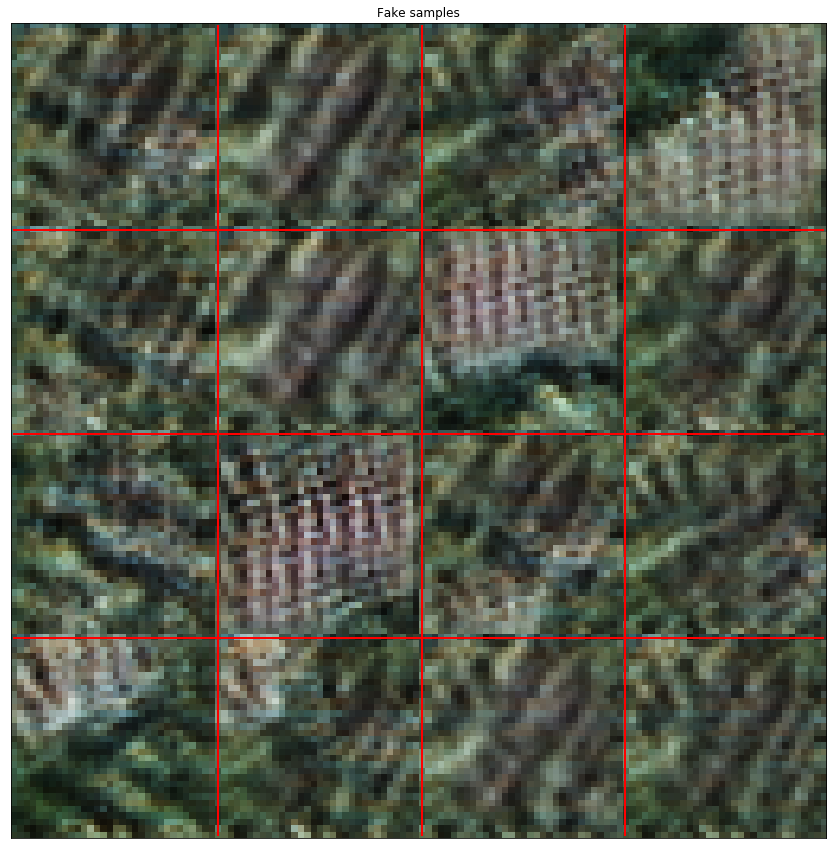

In [15]:
plt.figure(figsize=(15,15))
plot.draw_images(gen_sample,nx=4,ny=4);
plt.title("Fake samples");